In [421]:
# alternate OneHotEncoder

from sklearn import tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

df = df.dropna()
X = df[['degree', 'ST', 'Undergrad_GPA', 'GRE_V', 'GRE_Q', 'GRE_W', 'GRE_sub', 'USnew_stat_score', 'USnew_overall_score']]
y = df.admission_status
categorical_feature_mask = X.dtypes=='category'
ohe = ColumnTransformer(
    transformers=[
        ("OneHot",        # Just a name
         OneHotEncoder(), # The transformer class
         categorical_feature_mask # The column(s) to be applied on
        )
    ], remainder='passthrough' # donot apply anything to the remaining columns
)
X_ohe = ohe.fit_transform(X) # It returns an numpy array
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import plotnine as p9

In [444]:
%run "../code/clean"

In [445]:
# data preprocessing
# merge some categories
df.loc[df.admission_status=='Wait listed', 'admission_status'] = 'Other'
df.loc[df.admission_status=='Interview', 'admission_status'] = 'Other'
df.loc[df.degree=='Other', 'degree'] = 'Masters'
df.loc[df.admission_via=='Postal Service', 'admission_via'] = 'Other'
df.loc[df.admission_via=='Phone', 'admission_via'] = 'Other'
df.loc[df.ST=='O', 'ST'] = 'I'

### Decision Tree Classifier

**Response**

*admission_status*: Accepted, Rejected, Other

**Predictors**

*degree*: Masters, PhD

*admission_via*: E-mail, Other, Website

*ST* (source of students): I, A, U

*Undergrad_GPA*, *GRE_V*, *GRE_Q*, *GRE_W*, *GRE_sub*, *USnew_stat_score*, *USnew_overall_score*

**Steps**

1. encode categorical features (*degree*, *admission_via*, *ST*) as a one-hot numeric array.
2. split dataset into random train and test subsets.
3. train decision tree classifier and post prune decision trees with cost complexity pruning.

In [446]:
import graphviz
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

df = df.dropna()
X = df[['degree', 'admission_via', 'ST', 'Undergrad_GPA', 'GRE_V', 'GRE_Q', 'GRE_W', 'GRE_sub', 'USnew_stat_score', 'USnew_overall_score']]
y = df.admission_status
categorical_feature_mask = X.dtypes=='category'
ohe = OneHotEncoder(sparse=False)
X_ohe = ohe.fit_transform(X.loc[:, categorical_feature_mask])
X_ohe = pd.DataFrame(X_ohe, columns=ohe.get_feature_names(['degree', 'admission_via', 'ST']), index=X.index)
X = pd.concat([X_ohe, X.loc[:, ~categorical_feature_mask]], axis=1)

In [447]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

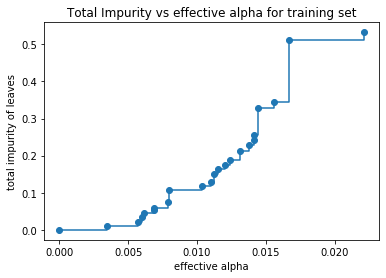

In [448]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [449]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.05927911697233923


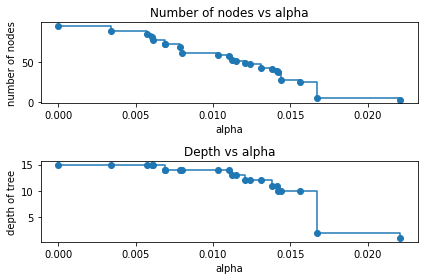

In [450]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

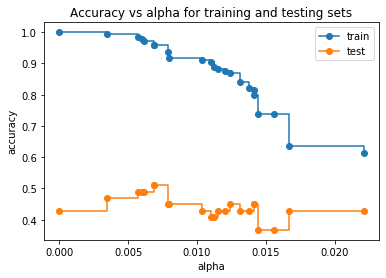

In [451]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

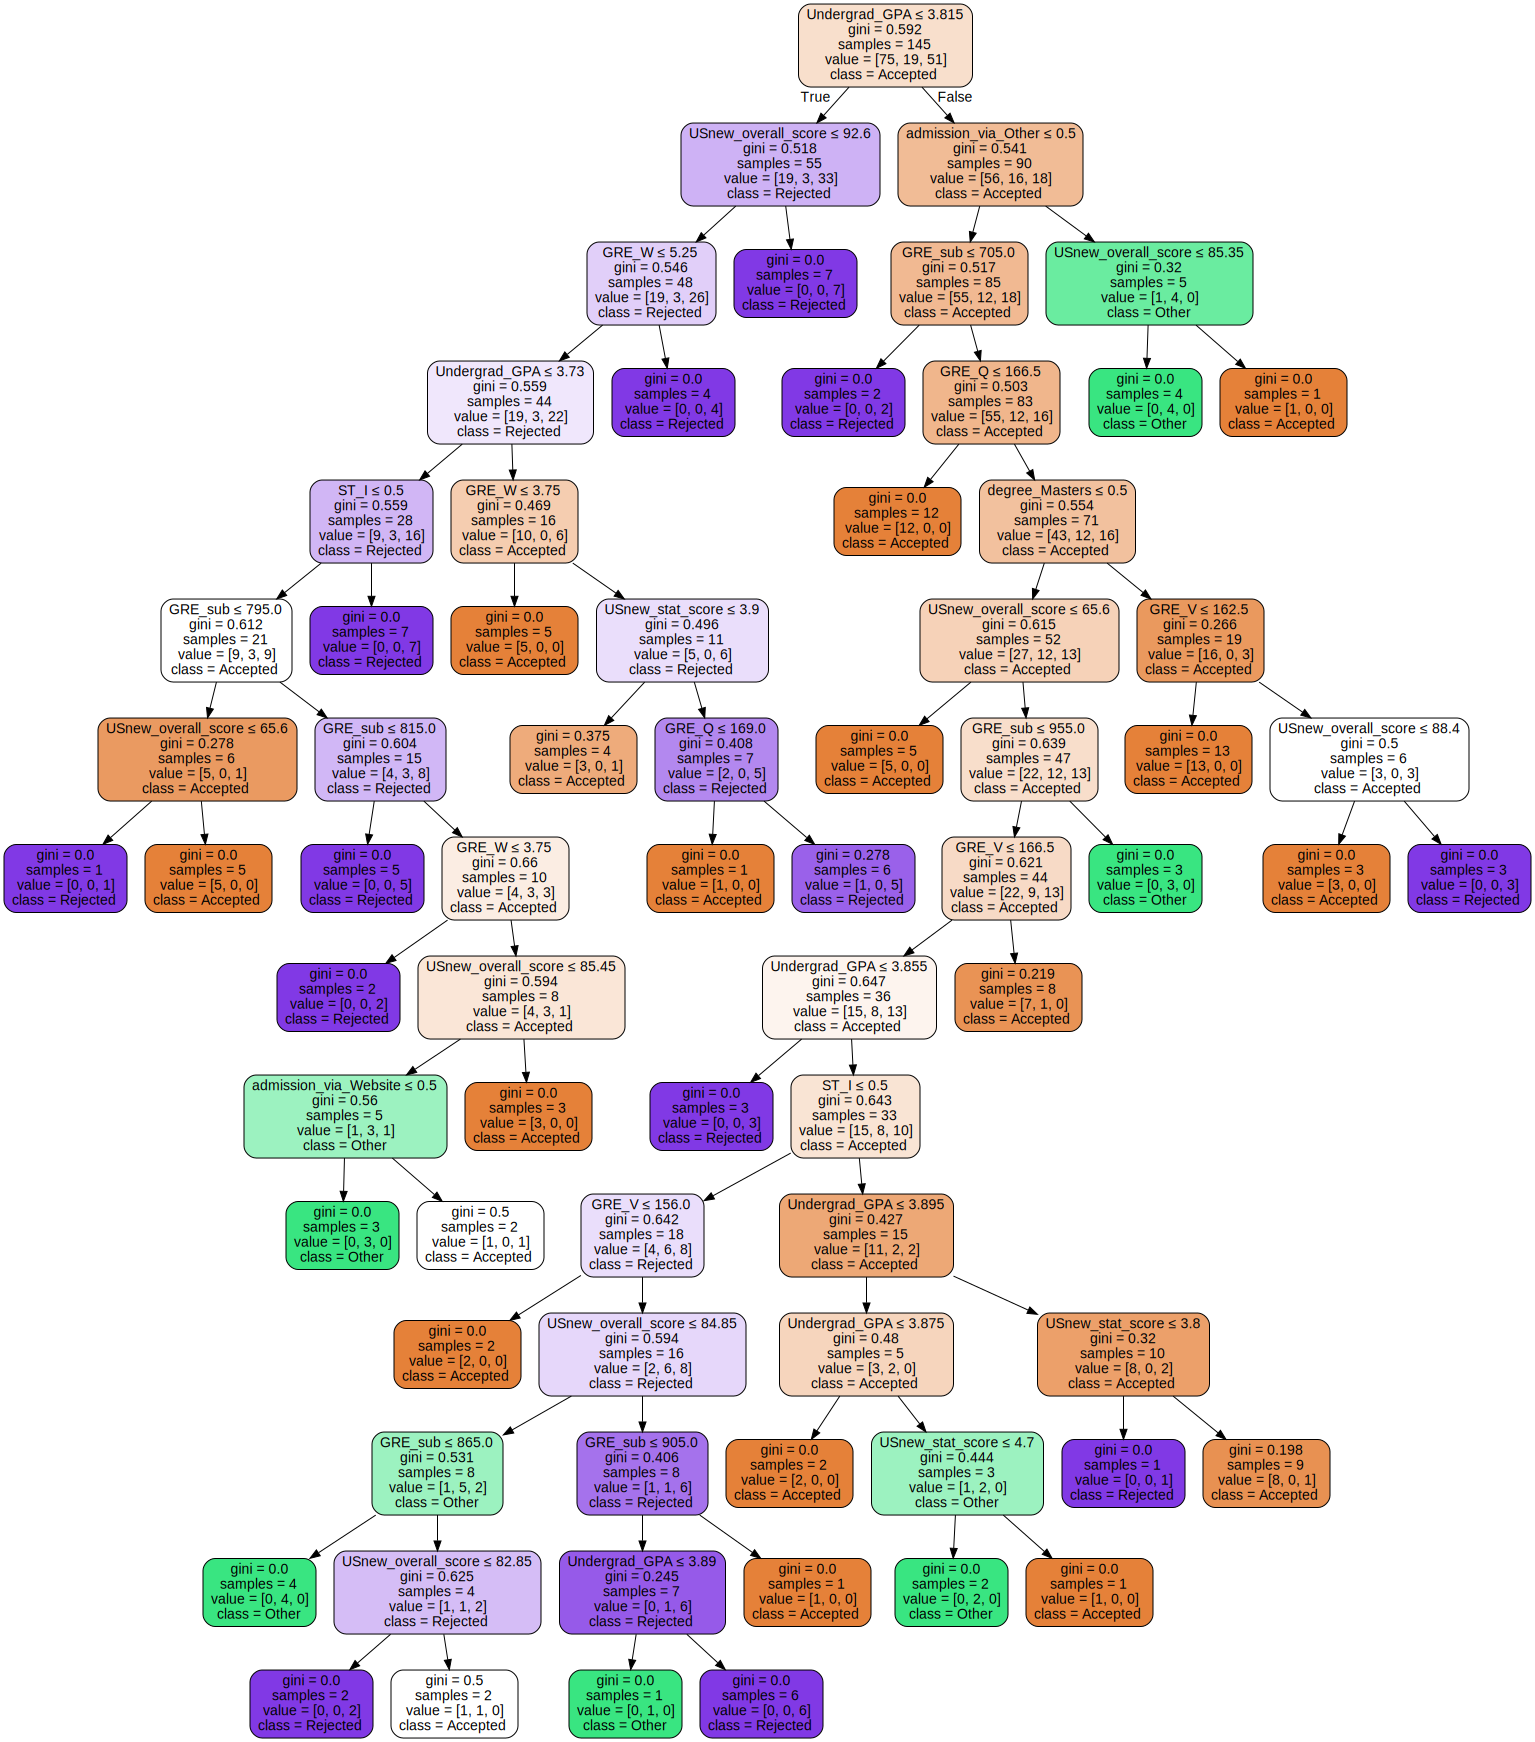

In [454]:
clfopt = clfs[np.argmax(test_scores)]
dot_data = tree.export_graphviz(clfopt, out_file=None,
                     feature_names=X.columns,
                     class_names=sorted(y.unique().tolist()),
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
# graph.render("status_tree")
graph

### Interpretation of result

Because of the large amount of missing data, the decision tree classifier does not perform very well in terms of prediction accuracy (0.51). Data imputation does not make sense in this case since almost all missing data happens in numerical variables such as GPA and GRE and missing is not random. We can neither impute randomly nor with other variables.

However, the classifier does provide some important interpretations towards graduate application (statistics). First, undergraduate GPA plays an essential role in graduate application (statistics). One needs to focus on his/her courses during undergraduate if he/she wants to apply for a competetive statistics graduate program. Second, GRE sub is important if undergraduate GPA is not competetive. Meanwhile, due to data limitation, we can not include other important factors, such as recommendation and undergraduate school, into our classifier, which may affect the performance of it.

1. GPA by year
2. GPA by degree
3. Location by degree

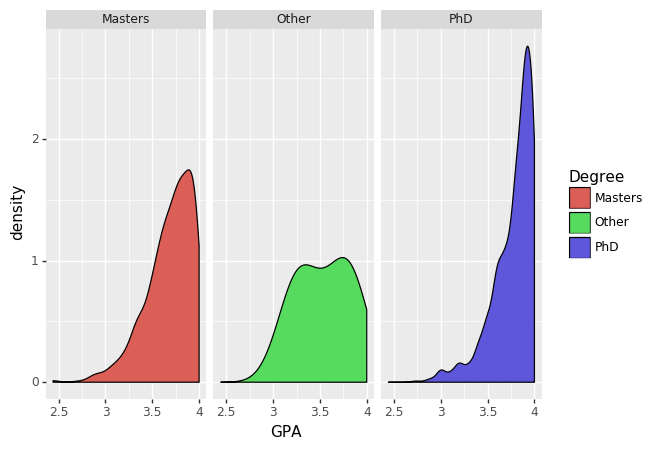

<ggplot: (-9223371944457930320)>

In [5]:
# GPA by degree
gg = p9.ggplot(df[~pd.isna(df.Undergrad_GPA)], p9.aes(x='Undergrad_GPA', fill='degree'))
gg += p9.geom_density()
gg += p9.scale_fill_discrete(name='Degree')
gg += p9.facet_wrap('~degree')
gg += p9.labs(x='GPA')
gg
# As expected, PhD applicants have much higher GPA

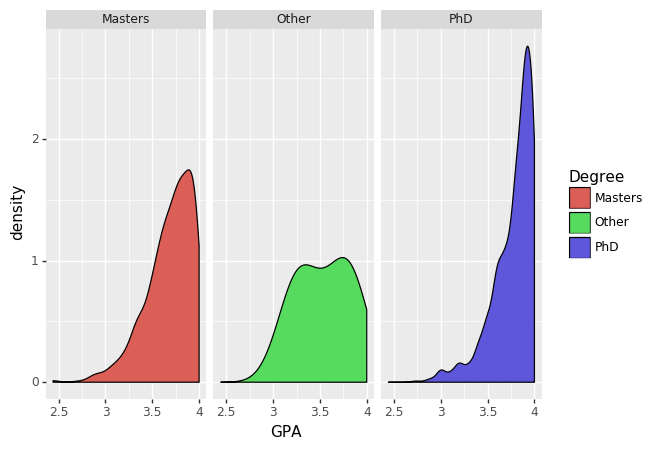

<ggplot: (-9223371944462021108)>

In [8]:
# GPA by degree
gg = p9.ggplot(df[~pd.isna(df.Undergrad_GPA)], p9.aes(x='Undergrad_GPA', fill='degree'))
gg += p9.geom_density()
gg += p9.scale_fill_discrete(name='Degree')
gg += p9.facet_wrap('~degree')
gg += p9.labs(x='GPA')
gg
# As expected, PhD applicants have much higher GPA

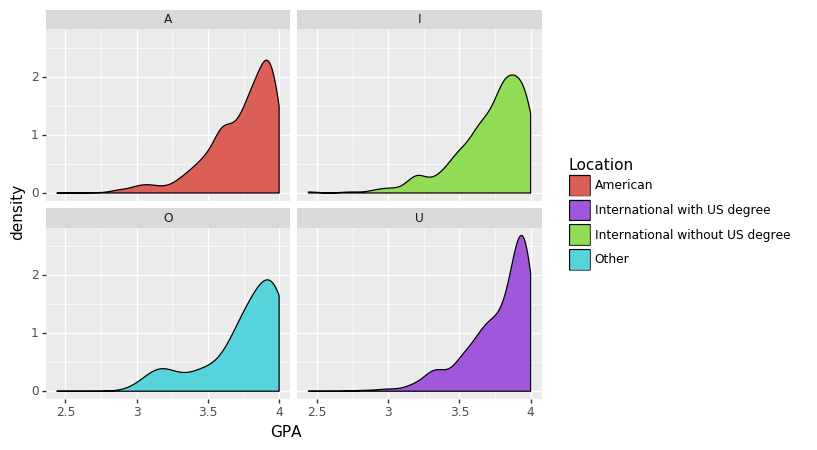

<ggplot: (-9223371944461864136)>

In [9]:
# GPA by location
loc = ['American', 'International with US degree', 'International without US degree', 'Other']

gg = p9.ggplot(df[(~pd.isna(df.Undergrad_GPA))&(~pd.isna(df.ST))], p9.aes(x='Undergrad_GPA', fill='ST'))
gg += p9.geom_density()
gg += p9.scale_fill_discrete(name='Location',breaks=['A', 'U', 'I', 'O'] , labels=loc)
gg += p9.facet_wrap('~ST')
gg += p9.labs(x='GPA')
gg
# International students with US degree tend to have higher GPA

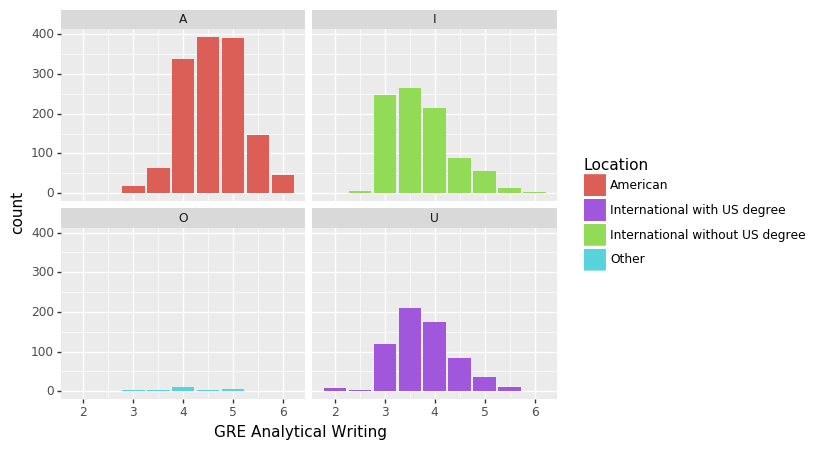

<ggplot: (-9223371944461721744)>

In [11]:
# GRE AW by location

gg = p9.ggplot(df[(~pd.isna(df.GRE_W))&(~pd.isna(df.ST))], p9.aes(x='GRE_W', fill='ST'))
gg += p9.geom_col(stat='count')
gg += p9.scale_fill_discrete(name='Location',breaks=['A', 'U', 'I', 'O'] , labels=loc)
gg += p9.facet_wrap('~ST')
gg += p9.labs(x='GRE Analytical Writing')
gg
# International students without US degree tend to have lower GRE AW

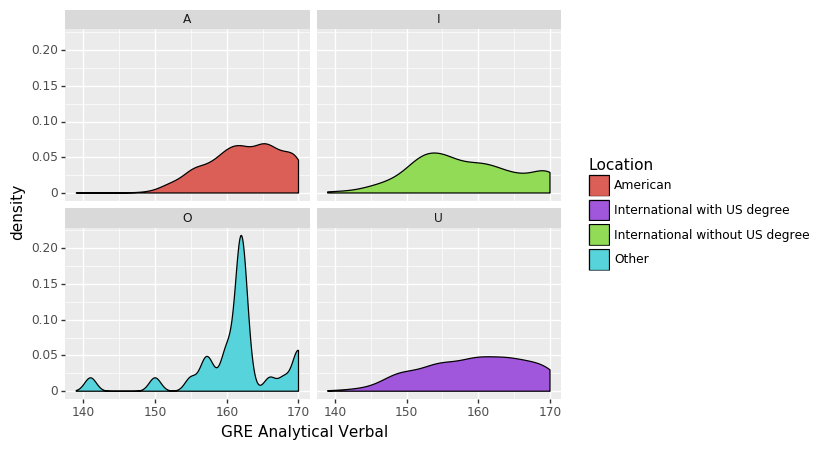

<ggplot: (-9223371944455992300)>

In [12]:
# GRE V by location

gg = p9.ggplot(df[(~pd.isna(df.GRE_V))&(~pd.isna(df.ST))], p9.aes(x='GRE_V', fill='ST'))
gg += p9.geom_density()
gg += p9.scale_fill_discrete(name='Location',breaks=['A', 'U', 'I', 'O'] , labels=loc)
gg += p9.facet_wrap('~ST')
gg += p9.labs(x='GRE Analytical Verbal')
gg
# International students without US degree tend to have lower GRE V

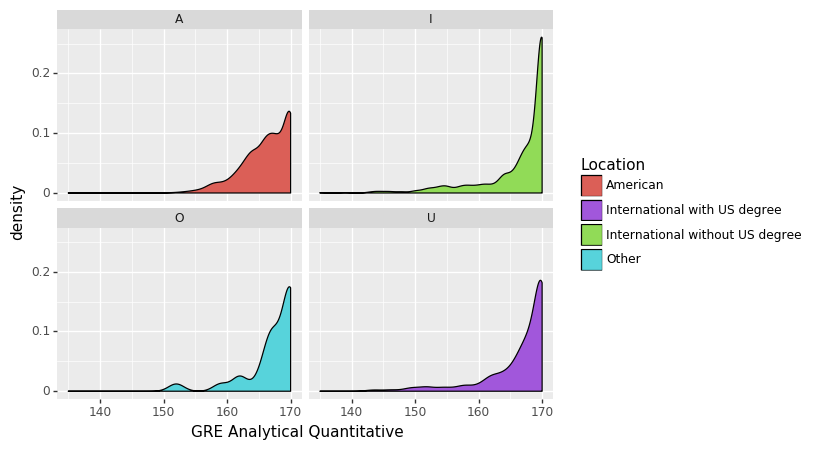

<ggplot: (-9223371944455300148)>

In [13]:
# GRE Q by location

gg = p9.ggplot(df[(~pd.isna(df.GRE_Q))&(~pd.isna(df.ST))], p9.aes(x='GRE_Q', fill='ST'))
gg += p9.geom_density()
gg += p9.scale_fill_discrete(name='Location',breaks=['A', 'U', 'I', 'O'] , labels=loc)
gg += p9.facet_wrap('~ST')
gg += p9.labs(x='GRE Analytical Quantitative')
gg
# International students without US degree tend to have higher GRE Q

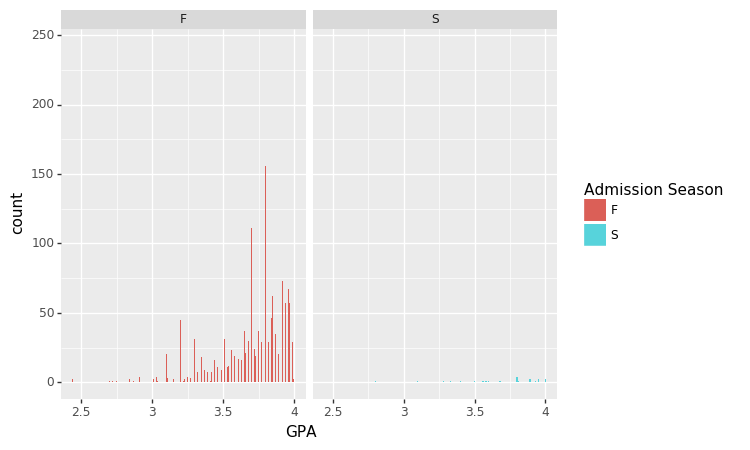

<ggplot: (-9223371944455300160)>

In [14]:
# GPA by season
df['fors'] = df.season.str[0:1]

gg = p9.ggplot(df.loc[(~pd.isna(df.Undergrad_GPA)), ], p9.aes(x='Undergrad_GPA', fill='fors'))
gg += p9.geom_col(stat='count') # add col geom
gg += p9.scale_fill_discrete(name='Admission Season')
gg += p9.facet_wrap('~fors')
gg += p9.labs(x = 'GPA')
gg

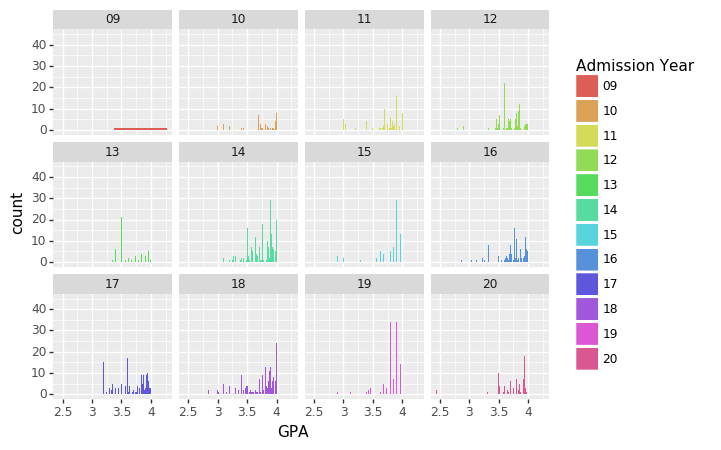

<ggplot: (-9223371944461561024)>

In [15]:
# GPA by year
df['year'] = df.season.str[1:]

gg = p9.ggplot(df.loc[(~pd.isna(df.Undergrad_GPA)), ], p9.aes(x='Undergrad_GPA', fill='factor(year)'))
gg += p9.geom_col(stat='count') # add col geom
gg += p9.scale_fill_discrete(name='Admission Year')
gg += p9.facet_wrap('~year')
gg += p9.labs(x = 'GPA')
gg

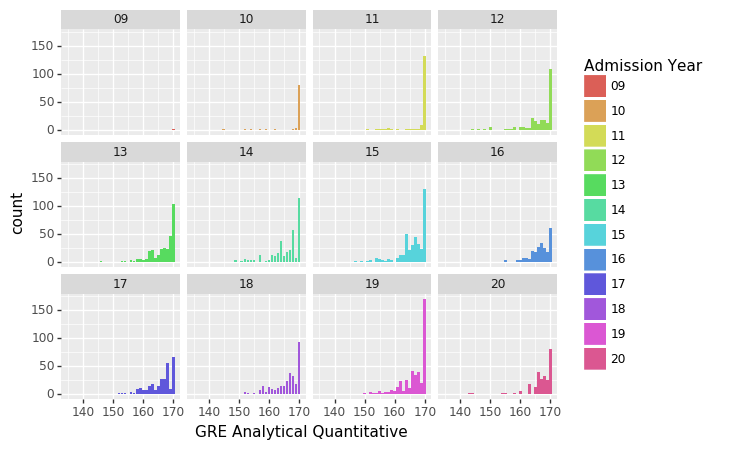

<ggplot: (-9223371944454770148)>

In [16]:
# GRE Q by year

gg = p9.ggplot(df.loc[(~pd.isna(df.GRE_Q)), ], p9.aes(x='GRE_Q', fill='factor(year)'))
gg += p9.geom_col(stat='count') # add col geom
gg += p9.scale_fill_discrete(name='Admission Year')
gg += p9.facet_wrap('~year')
gg += p9.labs(x = 'GRE Analytical Quantitative')
gg